# Module 4 Final Project

## Time Series Analysis

Name: Hazel Donaldson <br>
Pace: Part-time <br>
Review Date: <br>
Instructor Name: Victor Geislinger <br>

## 1. Introduction
In this project, I will be performing a time series analysis on historical housing data obtained from Zillow. I will be looking for the top 5 zipcodes a real estate developer should invest in (buy homes, renovate and rent to people). This investor is looking for busy, dense metropolitan areas with average house prices around the median. 

## 2. Libraries and Functions

In [40]:
# import necessary libraries for EDA, visualization and time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
import itertools 
import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [53]:
# add functions here
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def acf_pacf(df, alags=48, plags=48):
    #Create figure
    fig,(ax1, ax2) = plt.subplots(2,1, figsize=(13,8))
    #Create ACF plot
    plot_acf(df, lags=alags, zero=False, ax=ax1)
    #PACF plot
    plot_pacf(df, lags=plags, ax=ax2)
    plt.show()
    
def seasonal_plot(df, N=13, lags=[12,24,36,48,60,72]):
    #differencing the rolling mean to find seasonality in acf plot
    fig,(ax1, ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = TS_80631 - TS_80631.rolling(N).mean()
    plot_acf(rolling.dropna(), lags=lags, ax=ax1)
    plot_pacf(rolling.dropna(), lags=lags, ax=ax2)
    plt.show();
    
def train_test(df):
    train = df[:'2015-04']
    test = df['2015-05':]
    return train, test

def model_fit(df, pdq=(1,0,1), pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train, order= pdq, seasonal=pdqs)
    results = model.fit()
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show()
    return train, test, results

def test_RMSE(df,pdq=(1,0,1),pdqs=(0,0,0,1), display=True):
    X = df.values
    train, test = X[:-36],X[-36:]
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-36:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

def train_RMSE(train, results, display = True):
    train_pred = results.predict(-36)
    rmse = sqrt(MSE(train[-36:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()
        
def forecast_model(df, pdq=(1,0,1), pdqs=(0,0,0,1), display=True, zc='input zipcode'):
    model = SARIMAX(df, order=pdq, seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04', end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:, 1])
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

## 3. Import dataset

In [3]:
zillow_df = pd.read_csv('zillow_data.csv')
print(zillow_df.info(), '\n')
print(f'Unique amount of zipcodes: {zillow_df.RegionName.nunique()}')
zillow_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB
None 

Unique amount of zipcodes: 14723


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [ ]:
zillow_df.describe()

Looking at our data set, I can see that it is provided in wide-format. Further down, I will transform the data set into long format so that it is easier to read. There are 14,723 unique zipcodes in the data, so the next step will be to select the zipcodes that fit the investor's interests.

## 4. Data Preprocessing

In [4]:
# Find the zipcodes that are in highly urbanized areas
print(zillow_df.SizeRank.describe())
#Calculate 20% cutoff point
srank_20 = zillow_df.SizeRank.quantile(q=0.20)
print(f'Size Rank 20% cutoff value: {srank_20}')
#New dataframe
top_20_zc = zillow_df[zillow_df['SizeRank'] < srank_20].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
print(f'Amount of zipcodes: {len(top_20_zc)}')

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64
Size Rank 20% cutoff value: 2945.4
Amount of zipcodes: 2945


The number of zipcodes has been narrowed down to 2,945 from 14,723. Now I will narrow down the zipcodes to housing prices that hover around the median price. The average value will be calculated from last year's data as this the data the investor is mostly likely to encounter.

In [5]:
top_20_zc['yr_avg'] = top_20_zc.iloc[:,-12:].mean(skipna=True, axis=1)
print(top_20_zc['yr_avg'].describe())
q_60 = top_20_zc['yr_avg'].quantile(q=0.60)
q_35 = top_20_zc['yr_avg'].quantile(q=0.35)
print(f'Average Value for 60% cutoff rate: {round(q_60, 2)}')
print(f'Average Value for 35% cutoff rate: {round(q_35, 2)}')
pref_zc = top_20_zc[(top_20_zc['yr_avg'] < q_60) & (top_20_zc['yr_avg'] > q_35)]
print(f'Amount of zipcodes: {len(pref_zc)}')

count    2.945000e+03
mean     3.730666e+05
std      5.836511e+05
min      3.632500e+04
25%      1.691333e+05
50%      2.484083e+05
75%      3.978333e+05
max      1.858138e+07
Name: yr_avg, dtype: float64
Average Value for 60% cutoff rate: 290211.67
Average Value for 35% cutoff rate: 198641.67
Amount of zipcodes: 736


The number of zipcodes to consider is now 736. This takes in some of the requirements the investor is looking for: urbanization and median home value. Now, its time to look at things from an investment standpoint and calculate the return on investment and the coefficient of variance to take into account the risks involved. The return on investment or ROI is percentage increase in price. I will be calculating the ROI  between 2013-2018. This will represent the areas with the highest recent price uptrend. 

On the other hand, the investor will want to select areas where there is low volatility. It lowers risks when housing prices drop. The coefficient of variance is also used here, it's defined by the standard deviation divided by the mean. All 22 years of data is used here and null values are skipped. The higher the coefficient, the more volatile the zipcode.

In [6]:
pref_zc['roi'] = (pref_zc['2018-04']- pref_zc['2013-01'])/pref_zc['2013-01']
#calculate the standard deviation of monthly values
pref_zc['std'] = pref_zc.loc[:,'1996-04': '2018-04'].std(skipna=True, axis=1)
#calculate historic mean
pref_zc['mean'] = pref_zc.loc[:, '1996-04': '2018-04'].mean(skipna=True, axis=1)
#calculate the coefficient of variance
pref_zc['CV'] = pref_zc['std']/pref_zc['mean']
#show calculated values
pref_zc[['RegionName', 'std', 'roi', 'CV']].head(10)

,RegionName,std,roi,CV
11,32162,53805.394161,0.227694,0.292910
14,37013,19771.938500,0.696557,0.142048
17,37211,36496.608464,0.798502,0.247623
18,78660,24894.592870,0.437537,0.148012
22,77573,29647.359699,0.412973,0.161776
23,77584,27064.756641,0.378291,0.143482
31,78130,23349.861603,0.410077,0.152247
38,77429,25209.719327,0.397936,0.141715
45,77433,28113.378077,0.335095,0.148727
51,30043,24035.181933,0.648415,0.142436


In [7]:
#descriptive statistics for coefficient of variance
print(pref_zc['CV'].describe())
#define an upper limit for CV
upper_cv = pref_zc.CV.quantile(q=0.60)
print(f'Upper CV limit: {upper_cv}')
#get zipcodes with highest ROIs within risk profile
best_zc = pref_zc[pref_zc.CV < upper_cv].sort_values('roi', ascending=False, axis=0)[:5]
best_zc[['RegionName', 'roi', 'CV']].head(20)

count    736.000000
mean       0.238700
std        0.080020
min        0.056119
25%        0.171094
50%        0.226459
75%        0.291877
max        0.453303
Name: CV, dtype: float64
Upper CV limit: 0.25459687610566145


,RegionName,roi,CV
1235,80631,1.037433,0.239795
2419,97233,0.983516,0.248805
422,78758,0.898876,0.228653
2693,98444,0.832353,0.244243
2005,37214,0.811351,0.216641


In [8]:
#get location names
best_zipcodes = list(best_zc.RegionName.values)
for i in best_zipcodes:
    city = zillow_df[zillow_df['RegionName']== i].City.values[0]
    state = zillow_df[zillow_df['RegionName'] == i].State.values[0]
    print(f'Zipcode: {i}\n Location: {city}, {state}\n')

Zipcode: 80631
 Location: Greeley, CO

Zipcode: 97233
 Location: Portland, OR

Zipcode: 78758
 Location: Austin, TX

Zipcode: 98444
 Location: Parkland, WA

Zipcode: 37214
 Location: Nashville, TN



The data is still formatted in a wide format, with each month as a column. In order to perform a time series analysis, it needs to be formatted in long format, with month as a row.

In [9]:
TS_ZC5 = best_zc.drop(['yr_avg', 'std', 'mean', 'roi', 'CV'], axis=1)
TS_ZC5 =melt_data(TS_ZC5).set_index('time')
print('Time Series Data for top 5 zipcodes:\n', TS_ZC5.head())
dfs_ts = []
for zc in TS_ZC5.RegionName.unique():
    df = TS_ZC5[TS_ZC5['RegionName']==zc].asfreq('MS')
    dfs_ts.append(df)
dfs_ts[0].head()

Time Series Data for top 5 zipcodes:
             RegionName     value
time                            
1996-04-01       80631   86500.0
1996-04-01       97233  110800.0
1996-04-01       78758  129000.0
1996-04-01       98444  100400.0
1996-04-01       37214   88300.0


,RegionName,value
time,,
1996-04-01,80631,86500.0
1996-05-01,80631,87000.0
1996-06-01,80631,87500.0
1996-07-01,80631,87900.0
1996-08-01,80631,88400.0


## EDA and Visualization

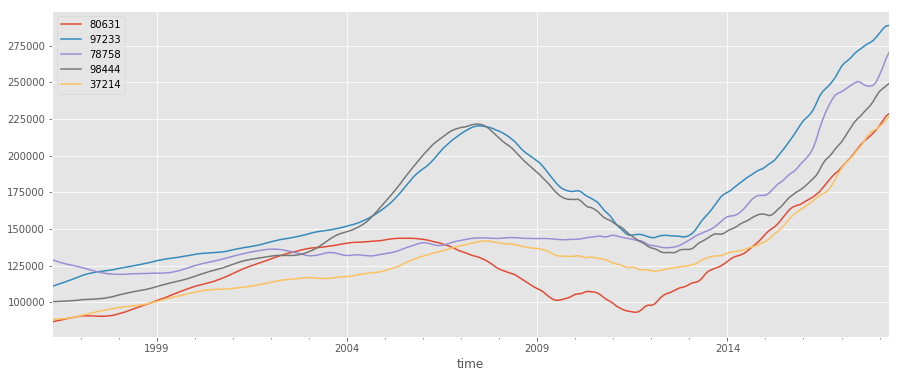

In [10]:
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].RegionName[0], figsize=(15,6))
    plt.legend()

The graph above shows the prices are about the same for the 22 year period and I can see that the housing trends for Portland (97233) and Parkland(98444) got higher and fell around the time of the great housing crash and recession of 2009. There is a bit of the a dip in the Greeley(80631) trend around the time of the housing crash. 

## Time Series Modeling

Since most of the prices in the housing trend graph above are similar, I will need a better way to compare the zipcodes. I will look at the monthly returns because the returns are comparable to each other and prices are dependent to the previous price.

In [11]:
# new column for monthly returns
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret'] = np.nan *len(dfs_ts)
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1] = (dfs_ts[zc].value.iloc[i+1]/dfs_ts[zc].value.iloc[i]) - 1

Before we can begin modeling, an important assumption needs to be confirmed: stationary. Stationary tells us that the mean is constant, the standard deviation is constant and there is not seasonality.

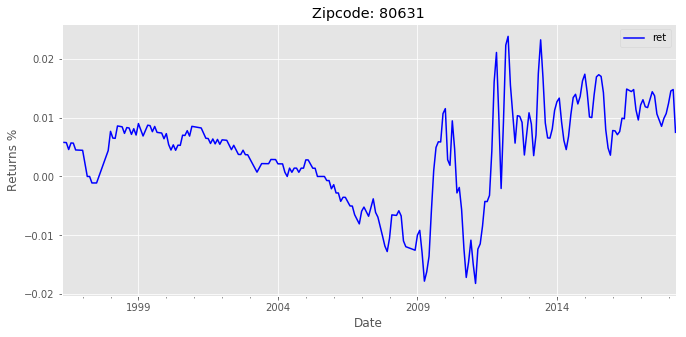

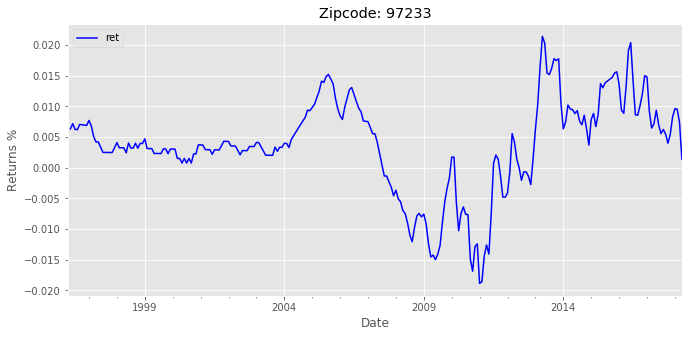

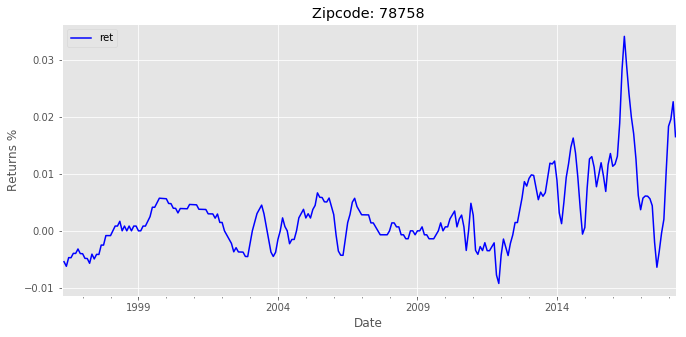

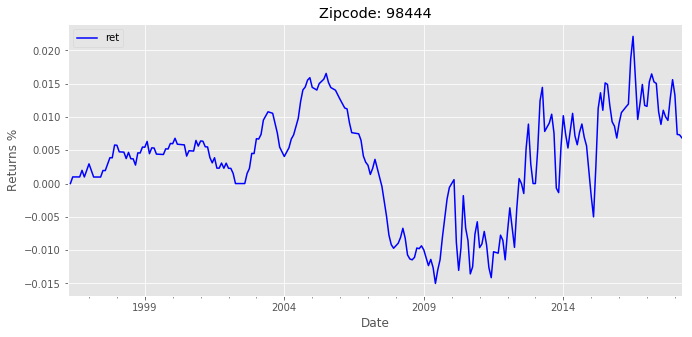

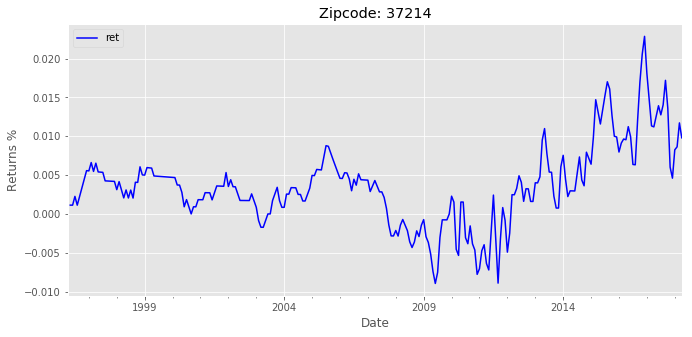

In [12]:
#plot the monthly returns for each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].ret.plot(figsize=(11, 5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns %')
    plt.legend(loc='best')
    plt.show()

All of the graphs above do not seem stationary but I will confirm this visually using rolling mean and rolling standard deviation.

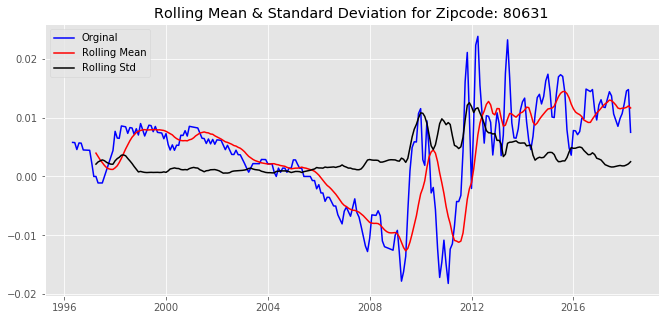

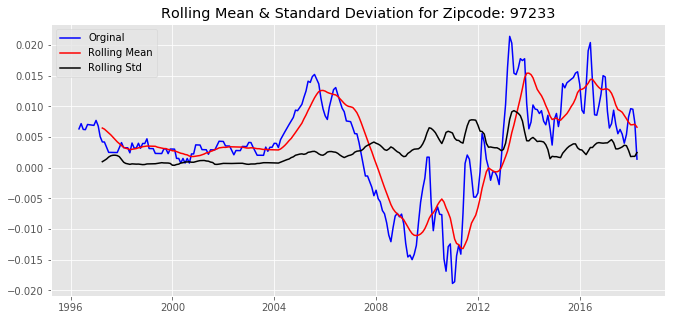

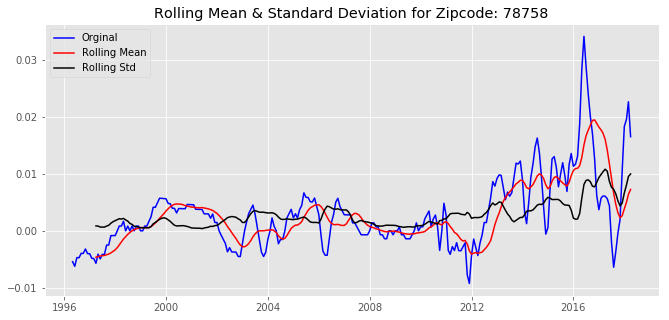

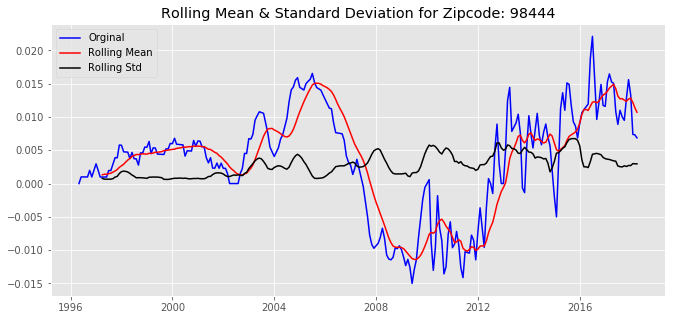

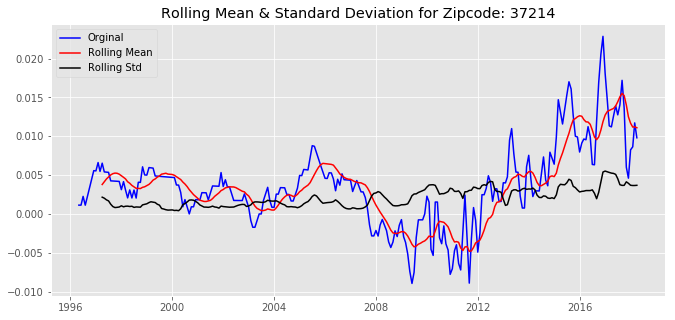

In [13]:
for i in range(len(dfs_ts)):
    rolmean= dfs_ts[i].ret.rolling(window=12, center=False).mean()
    rolstd = dfs_ts[i].ret.rolling(window=12, center=False).std()
    fig = plt.figure(figsize=(11, 5))
    orig = plt.plot(dfs_ts[i].ret,color='blue',label='Orginal')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

Visually, the data seems to not be stationary. However, I will challenge this visualizations using the Dickey-Fuller test and confirm whether or not the data is truly stationary. The Dickey-Fuller test is a statistical test of stationary in a time series. The null hypothesis of the Dickey-Fuller test say that the data is not stationary and the alternative hypothesis says the data is stationary. I will set the confidence level to 95% and I will reject the null hypothesis if there is p-value greater than 0.05.

In [14]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].RegionName[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 80631
P-value 0.710539628008088
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 97233
P-value 0.11396395166248763
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 78758
P-value 0.17369935135771158
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 98444
P-value 0.3107084009520179
Fail to reject the null hypothesis. The data is not stationary.

ADFuller test p-value for stationary: 37214
P-value 0.5467030124705775
Fail to reject the null hypothesis. The data is not stationary.



As we can see above, none of the zipcodes are stationary and will need to take the first difference to see the effect on stationary.

In [15]:
#take the order of intergration
for i in range(5):
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for stationary: {dfs_ts[i].RegionName[0]}')
    print('P-value',results[1])
    if results[1] > 0.05:
        print('Fail to reject the null hypothesis. The data is not stationary.\n')
    else:
        print('Reject the null hypothesis. The data is stationary.\n')

ADFuller test p-value for stationary: 80631
P-value 6.064327655106482e-10
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 97233
P-value 4.884612558355817e-08
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 78758
P-value 8.497498344953488e-09
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 98444
P-value 0.0006377881980377828
Reject the null hypothesis. The data is stationary.

ADFuller test p-value for stationary: 37214
P-value 2.7102862556018217e-07
Reject the null hypothesis. The data is stationary.



By taking the first difference of the data, all the data is now stationary. 

In [16]:
#create individual times series for each zipcode
TS_80631 = dfs_ts[0].ret.dropna() #zipcode 80631 monthly returns time series
TS_80631d = dfs_ts[0].ret.diff().dropna() # differenced time series

TS_97233 = dfs_ts[1].ret.dropna()
TS_97233d = dfs_ts[1].ret.diff().dropna()

TS_78758 = dfs_ts[2].ret.dropna()
TS_78758d = dfs_ts[2].ret.diff().dropna()

TS_98444 = dfs_ts[3].ret.dropna()
TS_98444d = dfs_ts[3].ret.diff().dropna()

TS_37214 = dfs_ts[4].ret.dropna()
TS_37214d = dfs_ts[4].ret.diff().dropna()

## Zipcode: 80631 (Greeley, CO)

To begin, I will plot the ACF and PACF to find the p and q parameter of this zipcode's SARIMA model. We have previously found the 'I' parameter to be 1 when we took the first difference.

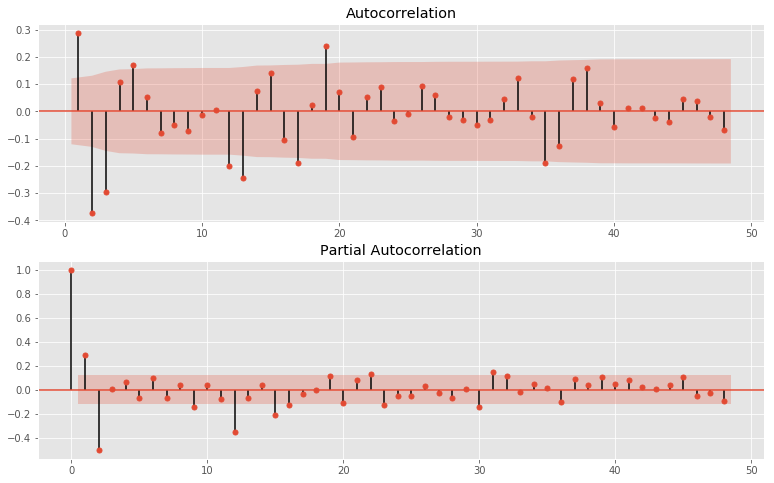

In [17]:
acf_pacf(TS_80631d)

From the plots, we can see that the ACF has 1 positive lag and two negative lags that are statistically significant so the MA(q) parameter is 1. The AR(p) is 2 or 3. Now, let's check for seasonality in the returns.

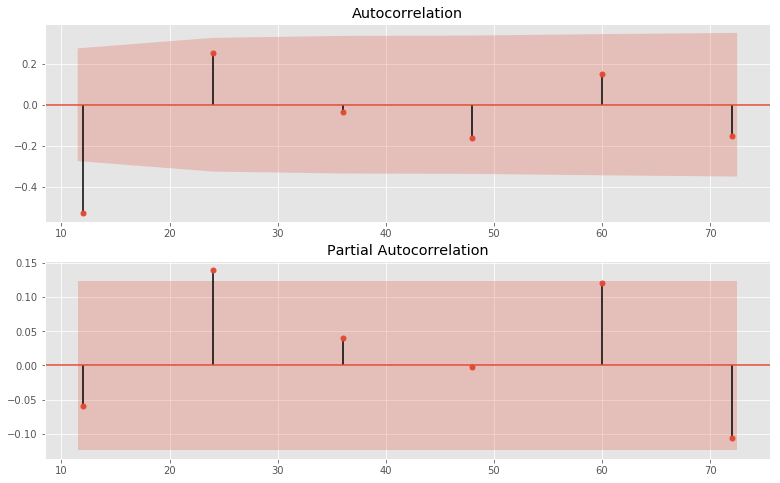

In [18]:
seasonal_plot(TS_80631d, N=13)

Since there is no statistically significant autocorrelation on lag 12 in the ACF plot, there is no seasonality in the data.

In [62]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_80631,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]


ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =-1736.824343558046
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =-1679.9767104208245
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-1650.7550354590217
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-1643.3838459283638
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-1721.688883545294
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-1740.1725629792077
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-1676.3175706306943
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-1668.0595954902792
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =-2018.71666146658
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =-1944.2560129035664
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-1870.642163995078
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-1874.3251282205401
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-1986.409795352335
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-1985.689067053342

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -2362.11
Name: 40, dtype: object

From the code above, we see our ARIMA parameters are p = 0, q=1 and P = 0, Q = 0. Let's proceed to see if these paramaters fit our model.

                           Statespace Model Results                           
Dep. Variable:                    ret   No. Observations:                  227
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 963.598
Date:                Tue, 08 Oct 2019   AIC                          -1921.195
Time:                        12:16:25   BIC                          -1910.934
Sample:                    06-01-1996   HQIC                         -1917.054
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4763      0.177      2.698      0.007       0.130       0.822
ma.L1         -0.7118      0.193     -3.690      0.000      -1.090      -0.334
sigma2      1.158e-05   9.94e-07     11.658      0.0

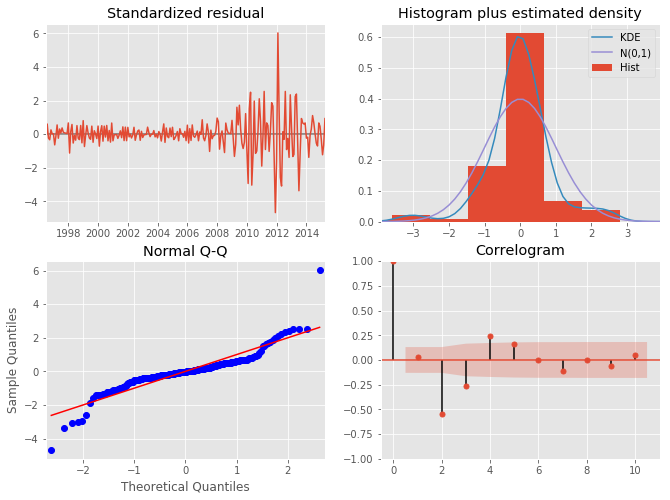

In [68]:
# fit SARIMA model
pdq = (1,1,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_80631d, pdq=pdq, pdqs=pdqs)

The seasonal ARIMA model seems to capture most of the signal from the monthly returns because the residuals on the Q-Q plot and histogram are normally distributed. Also the residuals look a lot like white noise. Now, we can proceed to the see how well the model fits the data.

SARIMA model RMSE on train data: 0.00445


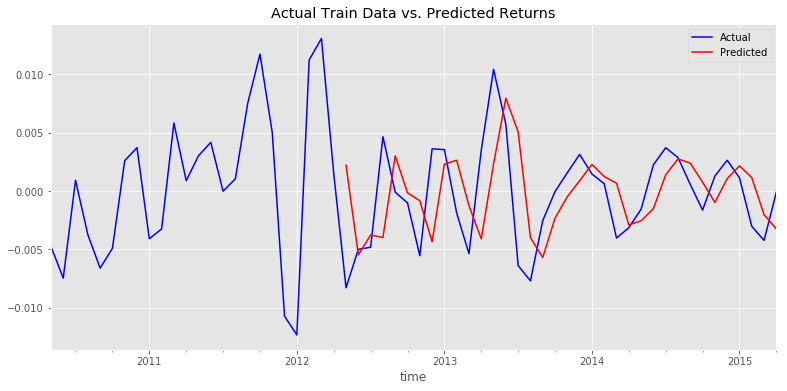

In [69]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00242


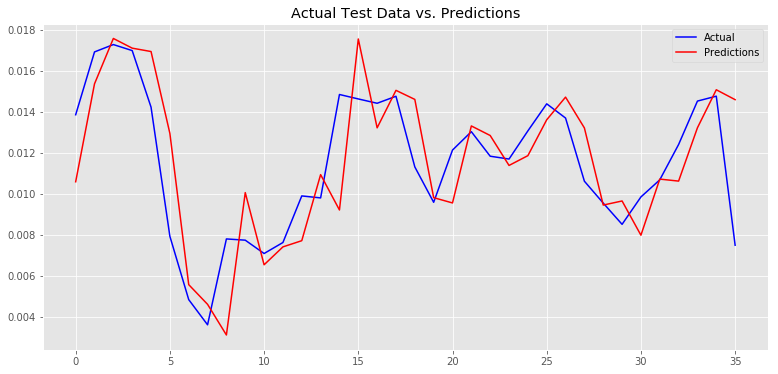

In [71]:
test_RMSE(TS_80631, pdq=pdq, pdqs=pdqs, display = True)

As we can see, the RMSEs for both are small but do not really fit the data well. However, the prediction plots follow a similar pattern to the actual data. Now we can calculate the out of sample forecasts to predict the total returns in one year, three years and five years. This process will be repeated for the four remaining zipcodes.

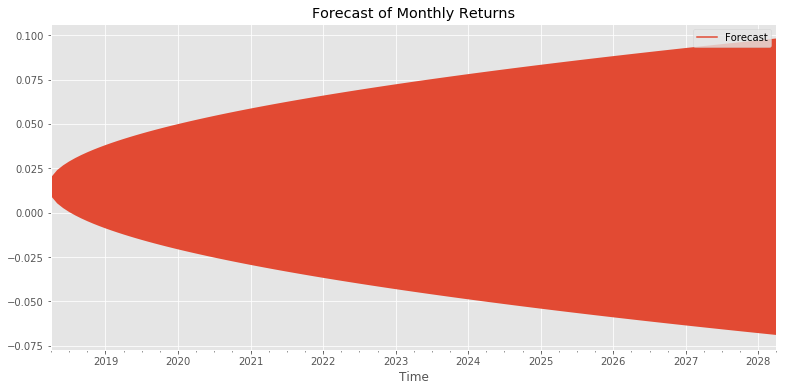

Total expected return in 1 year: 18.99%
Total expected return in 3 years: 68.48%
Total expected return in 5 year: 138.55%
Total expected return in 10 years: 477.37%


In [72]:
ret_80631 = forecast_model(TS_80631, pdq=pdq, pdqs=pdqs, zc = 80631)

# Alternate Idea

In [ ]:
#pull up original dataframe
zillow_df.head()

In [ ]:
#look at housing from state of texas
texas_df = zillow_df[zillow_df.State == 'TX']
texas_df.head()

In [ ]:
# what metro areas are in texas?
texas_df.Metro.nunique()

In [ ]:
#number of zipcodes in the state
len(texas_df.RegionName.unique()) 

In [ ]:
texas_df.SizeRank.describe()

In [ ]:
sr_20 = texas_df.SizeRank.quantile(q=0.20)
print(f'Size Rank 20% cutoff value: {sr_20}')
#New dataframe
top_20_zc = texas_df[texas_df['SizeRank'] < sr_20]
print(f'Amount of zipcodes: {len(top_20_zc)}')

In [ ]:
top_20_zc['yr_avg'] = top_20_zc.iloc[:,-12:].mean(skipna=True, axis=1)
print(top_20_zc['yr_avg'].describe())
q_60 = top_20_zc['yr_avg'].quantile(q=0.60)
q_35 = top_20_zc['yr_avg'].quantile(q=0.35)
print(f'Average Value for 60% cutoff rate: {round(q_60, 2)}')
print(f'Average Value for 35% cutoff rate: {round(q_35, 2)}')
pref_zc = top_20_zc[(top_20_zc['yr_avg'] < q_60) & (top_20_zc['yr_avg'] > q_35)]
print(f'Amount of zipcodes: {len(pref_zc)}')

In [ ]:
pref_zc['roi'] = (pref_zc['2018-04']- pref_zc['2013-01'])/pref_zc['2013-01']
#calculate the standard deviation of monthly values
pref_zc['std'] = pref_zc.loc[:,'1996-04': '2018-04'].std(skipna=True, axis=1)
#calculate historic mean
pref_zc['mean'] = pref_zc.loc[:, '1996-04': '2018-04'].mean(skipna=True, axis=1)
#calculate the coefficient of variance
pref_zc['CV'] = pref_zc['std']/pref_zc['mean']
#show calculated values
pref_zc[['RegionName', 'std', 'roi', 'CV']].head(10)

In [ ]:
print(pref_zc['CV'].describe())
#define an upper limit for CV
upper_cv = pref_zc.CV.quantile(q=0.60)
print(f'Upper CV limit: {upper_cv}')
#get zipcodes with highest ROIs within risk profile
best_zc = pref_zc[pref_zc.CV < upper_cv].sort_values('roi', ascending=False, axis=0)[:5]
best_zc[['RegionName', 'roi', 'CV']].head(20)

In [ ]:
#get location names
best_zipcodes = list(best_zc.RegionName.values)
for i in best_zipcodes:
    city = zillow_df[zillow_df['RegionName']== i].City.values[0]
    state = zillow_df[zillow_df['RegionName'] == i].State.values[0]
    print(f'Zipcode: {i}\n Location: {city}, {state}\n')

In [ ]:
# create indiviual dataframes for each zipcode
dfs_tx = []
for zc in best_zc.RegionName.unique():
    df = best_zc[best_zc['RegionName'] == zc]
    dfs_tx.append(df)

In [ ]:
dfs_tx

In [ ]:
best_zc